<a href="https://colab.research.google.com/github/thgml004949/ML_2022/blob/main/lab_5_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning - Lab Session 5

This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
- <font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.
- Commit the `.ipynb` file on your github repository and submit URL on E-Ruri

# 2 - LeNet

In this notebook, we will be implementing a modified version of [LeNet-5](http://yann.lecun.com/exdb/lenet/), a neural network model that uses convolutional neural network (CNN) layers and was designed for [classifying handwritten characters](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). CNNs are ubiquitous in modern computer vision. Almost every neural network model for computer vision contains many CNN layers, also referred to as convolutional layers, thus they're an important concept to understand. We will explain how they work when we implement the model.

The image below shows the architecture of LeNet-5. It consists of two convolutional layers, each followed by a subsampling layer, and then three fully connected linear layers.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Like the previous notebook, we'll implement LeNet, measure its performance on the MNIST dataset, and then have a short look into seeing what the model has learned.

Most of this notebook will be similar to the previous one, thus we will skim over code that has been shown before. We can look at the previous notebook for a refresher if needed.

### Data Processing

As always, we'll import the modules we need...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

...set the random seed for reproducability...

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

...and calculate the mean and standard deviation across our training set so we can normalize our data.

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Then, we'll define our train and test transforms...

In [4]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

...load our train and test data...

In [5]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

...and create a validation set from 10% of our training data.

Remember that the validation set should always be taken from the training data, and never the test data.

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

The validation set is using the same transforms as the training set, as it was created from it. As we want our validation set to remain static, to better resemble our test set, we replace these with the test transforms - remembering to `deepcopy` the validation set.

In [7]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

We'll print out the number of examples in the training/validation/test sets to ensure everything has been loaded correctly.

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


The final part of the data processing stage is to create our dataloaders/iterators.

Again, we use a batch size of 64 and only shuffle the training data each epoch.

In [9]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

### Defining the Model

The LeNet architectures, and almost every modern neural network computer vision architecture, makes use of convolutional neural network (CNN) layers. 

So, what is a CNN layer? Each convolutional layer has a number of *filters*, also commonly referred to as *kernels*. A filter is a (usually) square matrix that slides across the pixels in an image from left-to-right, top-to-bottom. At each "step", the filter performs a [convolution](https://en.wikipedia.org/wiki/Convolution) operation on the image. The output of the convolutional layer is the result of these convolutions after the filter's final "step". 

**Note:** in machine learning frameworks there aren't actually "steps", the result for every filter location is calculated at the same time, in parallel. This is a lot faster than actually stepping through the image, but thinking about it in terms of steps makes everything easier to visualize.

Let's have a look at a single 2x2 filter passing over an image. We'll pretend the image is 10x10 pixels in this example.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/filter-mnist.png?raw=1)

The filter (red) slides over the pixels of the image, stepping one pixel at a time. The size of the steps is called the *stride*, and we use a stride of one in this implementation, which means the filter moves one pixel at a time horizontally and moves one pixel down once it reaches the end of a row. The result of the convolution operation (green) is a pixel in the filtered image. All of these convolutions produce a new, filtered image.

Notice how the image coming out of the CNN layer is smaller than the image coming into the CNN. This is because the 2x2 filter has only nine steps horizontally and vertically. If we wanted to keep the output image the same size as the input image, we could add padding - usually black pixels - around our image. 

When we have no padding and a step size of one, the size of the output image is: 

$$\text{height}_{\text{out}} = \text{height}_{\text{in}} - \text{filter}_{\text{height}} + 1$$

$$\text{width}_{\text{out}} = \text{width}_{\text{in}} - \text{filter}_{\text{width}} + 1$$

How do we calculate the values of the output pixels using the filter? It's simply multiplying and adding! Each of the input image pixels covered by a filter is multiplied by the filter's weight over that pixel. All of these products are then summed together to get the value of the pixel in the output image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-filter.png?raw=1)

The same weights are used by the filter over the whole image. The weights do not change depending on the filter's location within the image. One nice thing about this is that the filters (and the convolutional layers themselves) are *translation invariant*, that means it doesn't matter where a feature (curve, edge, line) appears in an image, the convolutional layer will find all occurrences of it. 

The weights for the filters, much like the weights of the linear layers in multilayer perceptrons, are learned via gradient descent and backpropagation.

Why are convolutional neural networks structured in this way? Filters applied across an image in this way can be used to detect patterns such as horizontal and vertical lines within an image. These patterns can be thought of as features of the image, which our CNN extracts. These extracted features can then be combined in further layers of the neural network with other extracted features and together create higher level features, e.g. a certain position and orientation of two lines to make a cross, which can indicate the centre of a handwritten 4.

CNNs are also inspired by classic computer vision techniques, like [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator). Let's try manually choosing weights of a 3x3 filter to make Sobel filters and apply them to some MNIST digits to see what type of things our CNN layers can learn.

The `plot_filter` function takes in a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.

In [10]:
def plot_filter(images, filter):

    images = images = torch.cat([i.unsqueeze(0) for i in images],
                                dim=0).cpu()
    filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()

    n_images = images.shape[0]

    filtered_images = F.conv2d(images, filter)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = filtered_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Filtered')
        ax.axis('off')

We'll then get a batch of images to test our handwritten Sobel filters on. We get the images from the test set, as they're easier to examine without the transforms applied to them.

In [11]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter is for detecting horizontal lines.

We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all the digits.

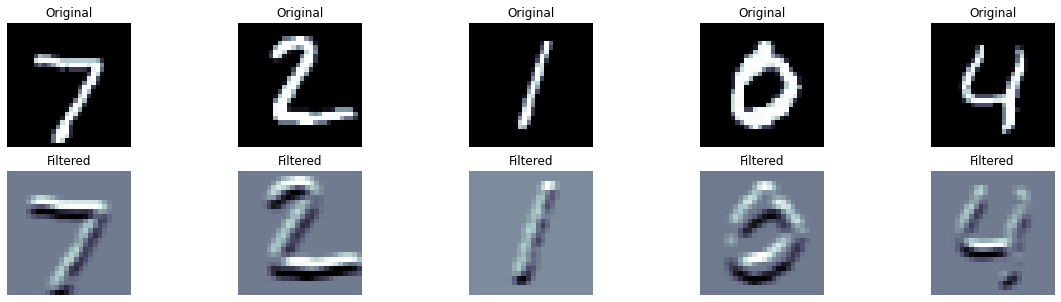

In [12]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

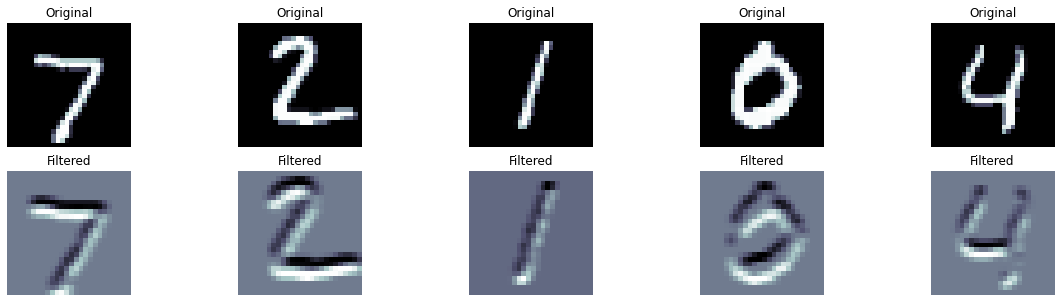

In [13]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

We can also design filters that detect vertical lines. 

Here's one that detects vertical lines that are black on the left and white on the right.

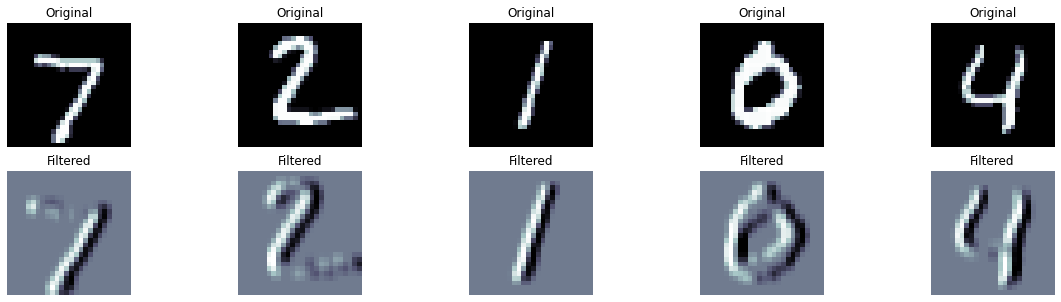

In [14]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

To get the opposite filter, one that detects vertical lines that are white on the left and black on the right, we swap the left and right columns.

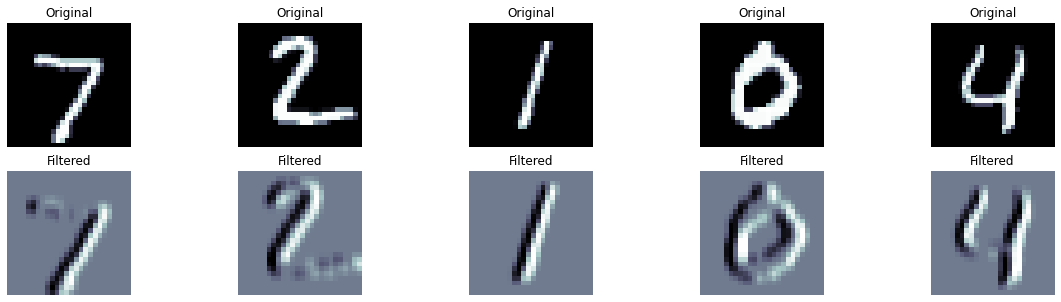

In [15]:
vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

Finally, we'll design a diagonal detecting filter. This one detects lines pointing towards the top right of the image.

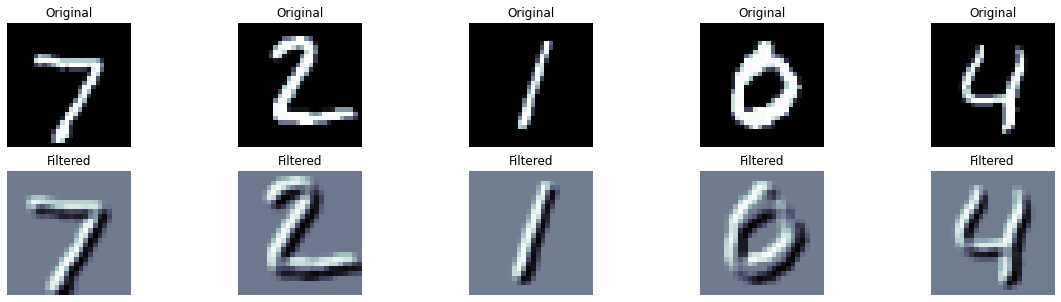

In [16]:
diagonal_filter = [[-2, -1, 0],
                   [-1,  0, 1],
                   [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has their own set of weights, so (in theory) is learning to extract different features. 

The image below shows what happens when we use a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.  

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-filter-mnist.png?raw=1)

What about when you now want to pass this five channel filtered image to another convolutional layer? Now, that convolutional layer won't just have a height and a width, but it will also have a depth equal to the number of channels in the input image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-channel-mnist.png?raw=1)

As you can see, the filter has a height, width and depth of 2x2x5. All the 20 pixel values covered by this filter are multiplied by the filter's weight and then summed. The result of this will have as many channels as there are filters, and a subsequent convolutional layer will have to have filters with a depth equal to that number of channels.

Hopefully that's enough on convolutional layers, but if not, then there are [plenty](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) of [other](https://cs231n.github.io/convolutional-networks/) resources [about](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) them [online](https://www.coursera.org/learn/convolutional-neural-networks).

Next, we'll talk about the subsampling layers. These are layers used to reduce the size/resolution of their input and are commonly applied to the output of convolutional layers. The most common two methods of subsampling are *max pooling* and *mean pooling* (also known as *average pooling*), and thus subsampling is often know as *pooling*.

Why do we want to reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and half the size of our image before it passes into the next convolutional layer, that's a significant speed-up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any parameters - weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter, and we can think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter and we can think of it as equally weighting all features under the filter.

Let's look at a 2x2 pooling operation, with a stride of 2, over an image:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/subsample-mnist.png?raw=1)

Commonly, and by default in PyTorch, the stride for the height and the width is the height and the width of the filter and each pixel is only seen by the pooling layer once, thus:

$$\text{height}_{\text{out}} = \frac{\text{height}_\text{in}}{\text{filter}_{\text{height}}}$$

$$\text{width}_{\text{out}} = \frac{\text{width}_\text{in}}{\text{filter}_{\text{width}}}$$

For max pooling, the value of the output for each filter location is:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-pool.png?raw=1)

Let's create a function that allows us to see the outputs of a pooling layer on a batch of images.

In [17]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()

    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')

    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size=pool_size)

    fig = plt.figure(figsize=(20, 5))

    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title('Subsampled')
        ax.axis('off')

First, let's see max pooling with a filter size of 2. 

We can see that the image is heavily downsampled - reduced in size/resolution and in quality.

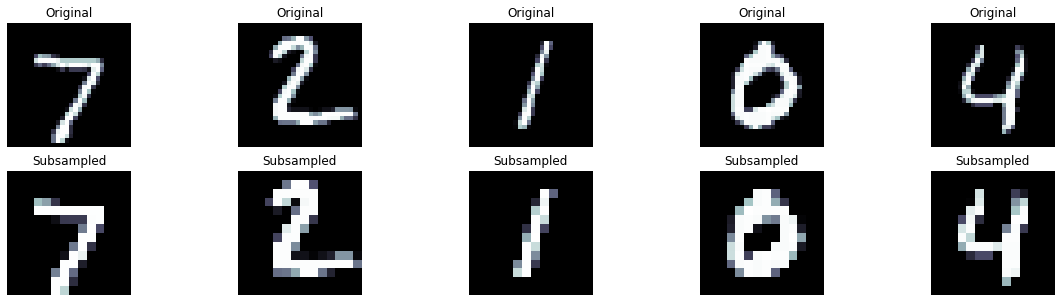

In [18]:
plot_subsample(images, 'max', 2)

If we increase the size of the max pooling filter, the images get smaller and the quality gets worse.

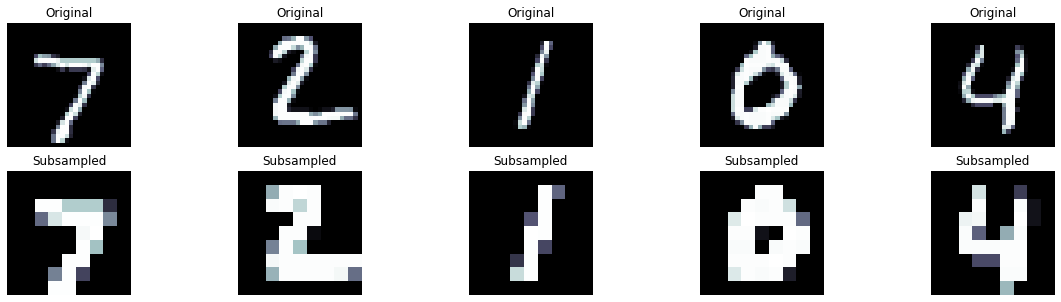

In [19]:
plot_subsample(images, 'max', 3)

For average pooling, the same effect happens, however the loss in quality is not as harsh.

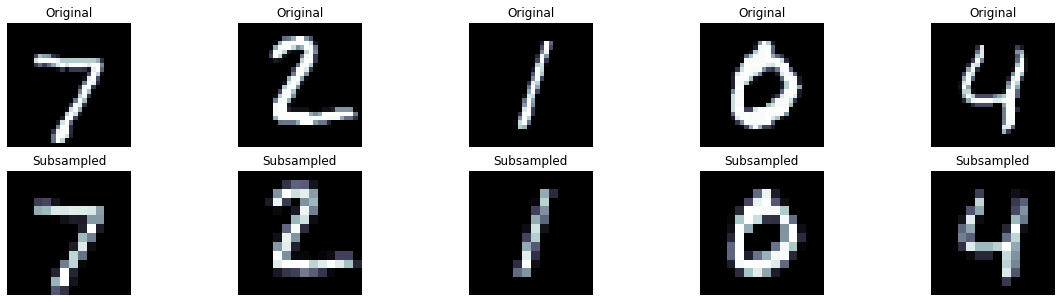

In [20]:
plot_subsample(images, 'avg', 2)

Again, we can increase the filter size, reducing the resolution of the output image at the cost of image quality - however, the quality drop is not as bad as max pooling.

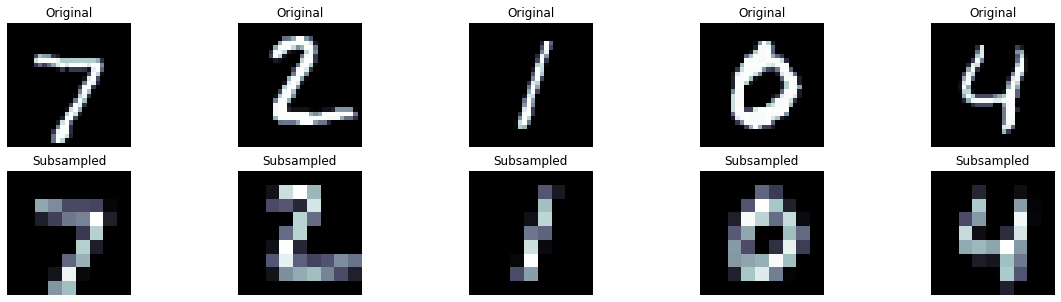

In [21]:
plot_subsample(images, 'avg', 3)

Similarly to convolutional layers, if the input image has more than one channel, the filter has a depth equal to the number of channels. Thus, if we did a max pool with a 5x5x6 filter (height and width of 5 and depth of 6), the output at each pixel would be the maximum value of all 150 pixels covered by the filter.

### Defining the Model

Now we've gone through all the concepts, we can implement our model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Our actual implementation is going to slightly differ from the actual LeNet architecture, as it was built to handle 32x32 images, whereas the MNIST dataset consists of 28x28 images. We're also not going to use the Gaussian connections at the end, instead we'll just use a standard linear layer.

The first layer in our model is a convolutional layer with 6 filters (PyTorch calls them `out_channels`) and a kernel size of 5. This turns our `[1, 28, 28]` image into `[6, 24, 24]`. We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the of the image. 

Afterwards, we pass the image to the second convolutional layer with 16 filters that are 5x5x6, a height and width of 5 and a depth of 6 as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the height and width to `[16, 4, 4]` and then pass through another ReLU function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

Note that you should always apply your activation function **after** the pooling layer. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to fewer inputs and thus use less computation.

Output Size Calculation Formula

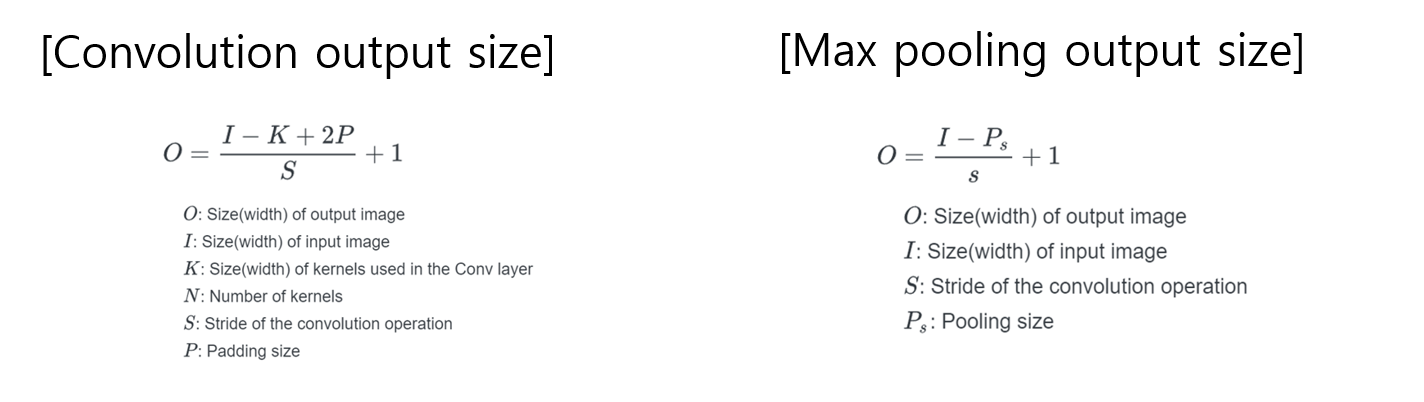


LeNet model architecture 

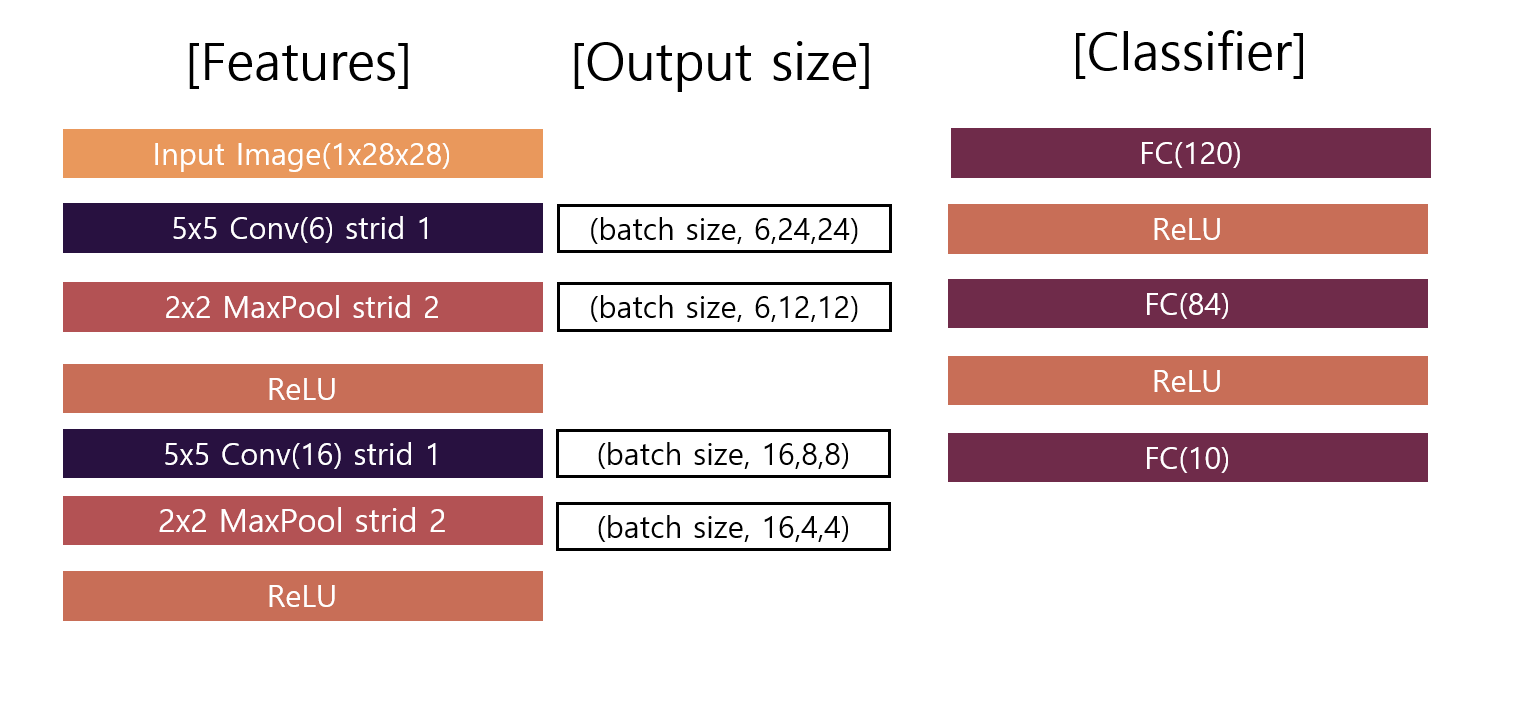

In [22]:
from torch.nn.modules.activation import ReLU
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        #Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)

        self.features = nn.Sequential(

            nn.Conv2d(1,6,5,),    #Conv2D  인풋채널 = 1 (흑백영상이라서), 아웃풋채널 = 6, 커널 사이즈 5 stride는 기본으로 1로 지정
            nn.MaxPool2d(2),    #커널 사이즈 2X2인데 2로 지정
            nn.ReLU(inplace=True),   #메모리에 조금 더 효율적이라서 사용. 
            nn.Conv2d(6,16,5,),   
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)

         )

        self.classifier = nn.Sequential(
            nn.Linear(16*4*4, 120),   #마지막 피쳐맵의 사이즈
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, output_dim)
         )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

The rest of the notebook is similar to the previous ones.

We'll create an instance of the model...

In [23]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

...and calculate the number of parameters. 

Notice that this model has significantly fewer parameters than the previous model: 44,000 parameters compared to 222,000.

In [24]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


### Training the Model

We define our optimizer...

In [25]:
optimizer = optim.Adam(model.parameters())

...our loss function (which will also apply the softmax activation function)...

In [26]:
criterion = nn.CrossEntropyLoss()

...define the device (to put our model and data on the GPU, if we have one)...

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

...place the model and criterion on the device...

In [28]:
model = model.to(device)
criterion = criterion.to(device)

...define a function to calculate accuracy...

In [29]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...define a function that performs a training epoch...

In [30]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        # assign data to device
        x = x.to(device)
        y = y.to(device)

        # clear the previous gradient
        optimizer.zero_grad()

        # feed forward
        y_pred, _ = model(x)

        # compute loss (error)
        loss = criterion(y_pred, y)

        # compute accuracy

        acc = calculate_accuracy(y_pred, y)

        # back propagation
        loss.backward()


        # gradient decent
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that performs an evaluation epoch...

In [31]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
  
          x = x.to(device)
          y = y.to(device)

          y_pred, _ = model(x)

          loss = criterion(y_pred, y)

          acc = calculate_accuracy(y_pred, y)


          epoch_loss += loss.item()
          epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that tells us how long an epoch takes...

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

...and finally we can begin training!

Even though we have significantly fewer parameters, the model still takes around the same amount of time per epoch (convolutional layers are computationally expensive) and we train it a bit longer.

However, we beat the ~98% validation accuracy achieved by the multilayer perceptron model and achieve 99% validation accuracy.

In [33]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in trange(EPOCHS, desc="Epochs"):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 34s
	Train Loss: 0.418 | Train Acc: 86.50%
	 Val. Loss: 0.118 |  Val. Acc: 96.43%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 40s
	Train Loss: 0.136 | Train Acc: 95.70%
	 Val. Loss: 0.087 |  Val. Acc: 97.43%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 35s
	Train Loss: 0.101 | Train Acc: 96.80%
	 Val. Loss: 0.077 |  Val. Acc: 97.88%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 35s
	Train Loss: 0.085 | Train Acc: 97.36%
	 Val. Loss: 0.064 |  Val. Acc: 98.09%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.069 | Train Acc: 97.80%
	 Val. Loss: 0.058 |  Val. Acc: 98.18%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 35s
	Train Loss: 0.065 | Train Acc: 97.94%
	 Val. Loss: 0.050 |  Val. Acc: 98.56%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 34s
	Train Loss: 0.061 | Train Acc: 98.12%
	 Val. Loss: 0.045 |  Val. Acc: 98.73%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 34s
	Train Loss: 0.053 | Train Acc: 98.31%
	 Val. Loss: 0.048 |  Val. Acc: 98.60%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 34s
	Train Loss: 0.052 | Train Acc: 98.38%
	 Val. Loss: 0.045 |  Val. Acc: 98.74%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 34s
	Train Loss: 0.047 | Train Acc: 98.50%
	 Val. Loss: 0.045 |  Val. Acc: 98.67%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 34s
	Train Loss: 0.047 | Train Acc: 98.55%
	 Val. Loss: 0.042 |  Val. Acc: 98.70%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 34s
	Train Loss: 0.044 | Train Acc: 98.61%
	 Val. Loss: 0.042 |  Val. Acc: 98.68%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 34s
	Train Loss: 0.040 | Train Acc: 98.75%
	 Val. Loss: 0.049 |  Val. Acc: 98.65%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 34s
	Train Loss: 0.040 | Train Acc: 98.72%
	 Val. Loss: 0.041 |  Val. Acc: 98.95%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 34s
	Train Loss: 0.039 | Train Acc: 98.73%
	 Val. Loss: 0.037 |  Val. Acc: 98.89%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 34s
	Train Loss: 0.035 | Train Acc: 98.86%
	 Val. Loss: 0.050 |  Val. Acc: 98.57%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 34s
	Train Loss: 0.036 | Train Acc: 98.87%
	 Val. Loss: 0.036 |  Val. Acc: 98.97%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 35s
	Train Loss: 0.034 | Train Acc: 98.90%
	 Val. Loss: 0.037 |  Val. Acc: 99.00%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 35s
	Train Loss: 0.033 | Train Acc: 98.97%
	 Val. Loss: 0.036 |  Val. Acc: 98.95%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 35s
	Train Loss: 0.032 | Train Acc: 99.04%
	 Val. Loss: 0.045 |  Val. Acc: 98.79%


We load the parameters which performed the best on the validation set and then evaluate our performance on the test set.

Just like the validation accuracy, we get 99% test accuracy!

In [34]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.027 | Test Acc: 99.20%


### Examining the Model

Much like the previous notebook, we'll examine our model by: plotting a confusion matrix, seeing which incorrect examples our model was most confident about, view our model's learned representations in two dimensions with PCA and t-SNE, and view the weights of our model.

First, we'll get the model's predictions across the test set...

In [35]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [36]:
images, labels, probs = get_predictions(model, test_iterator, device)

...and then get the predicted labels from the model's predictions.

In [37]:
pred_labels = torch.argmax(probs, 1)

Next, we'll plot the confusion matrix.

In [38]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

The only real problem the model seemed to have is predicting 2s as 7s.

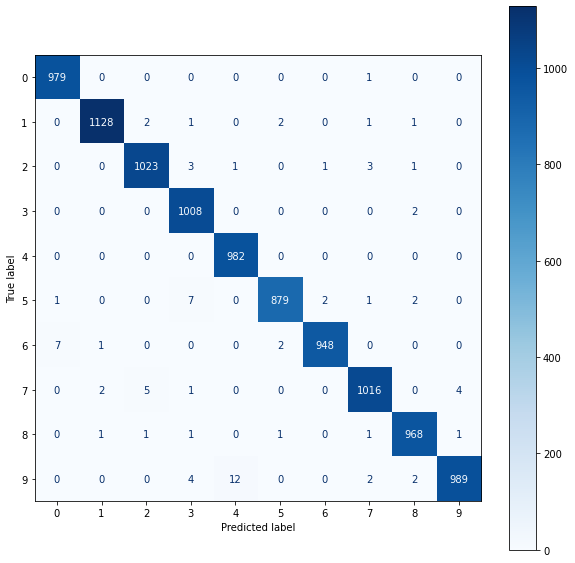

In [39]:
plot_confusion_matrix(labels, pred_labels)

Next, we'll find out which of our examples are correct...

In [40]:
corrects = torch.eq(labels, pred_labels)

...then get all of the incorrect examples and sort them by descending confidence in their prediction.

In [41]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)

We can then use this to plot the examples the model got wrong and was most confident about.

In [42]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

The mistakes look pretty reasonable. All the digits shown here are a bit off.

As mentioned in the previous notebook, the model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

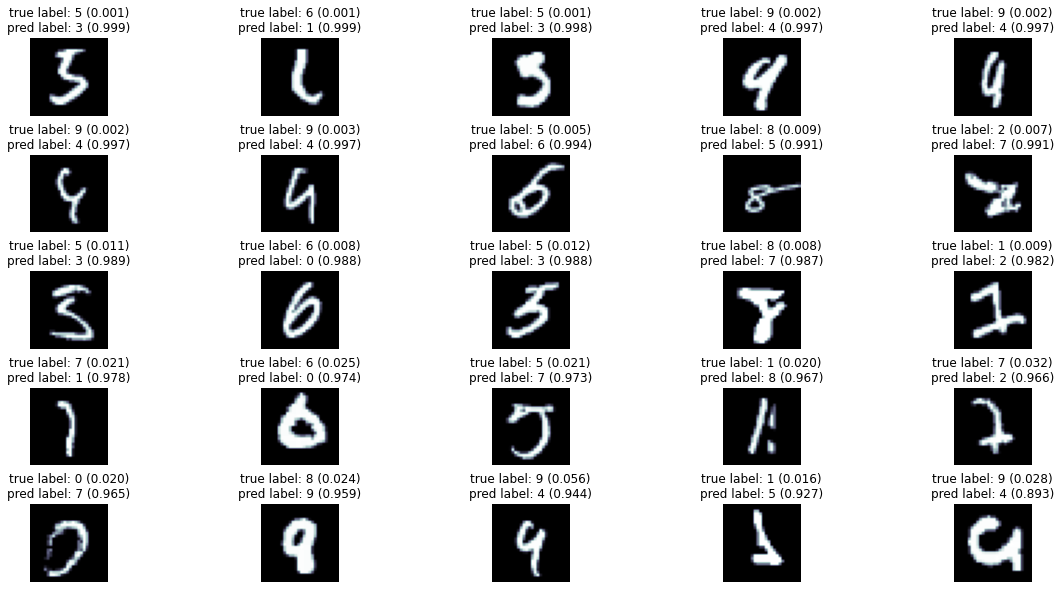

In [43]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

Let's move on to plotting the model's representations in lower dimensions, so we can visualize them.

First, we'll get the representations from the model...

In [44]:
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator):

            x = x.to(device)

            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

In [45]:
outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

As before, we can try generating a perfect handwritten digit by repeatedly generating a batch of noise and storing the noise that gave us the highest probability of being the digit we want. 

Surely as we now have convolutional layers that look for edges and curves we should get something more sensible, right?

In [46]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 1, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

As we can see below, no. We get random noise with a >99% confidence that it's a three. 

Again, our model has been trained to be confident in its predictions and thus will be even for random noise. This is a flaw of neural networks and is a reason why [adversarial examples](https://openai.com/blog/adversarial-example-research/) work so well.

In [ ]:
DIGIT = 3

best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [ ]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

In [ ]:
plt.imshow(best_image.squeeze(0).cpu().numpy(), cmap='bone')
plt.axis('off');

Remember how we defined the Sobel filters early on in this tutorial? Well, as convolutional layers learn their own values for their filters, we can do the same thing and see how our filters process images.

Let's define a function that takes a batch of images and multiple filters, which it then uses on the images.

In [ ]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap='bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off')

Some of our filters look for areas of black pixels, which has the effect of inverting our images. Some apply a blur effect, which is similar to [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur) effects used in image processing to reduce noise in the image. Some detect edges, like our Sobel filters we created earlier.

There is no guarantee each filter will learn a unique filtering effect. They are initialized randomly, and some filters may learn very similar weights. Therefore, it does not necessarily mean that using more filters will give a better performance.

In [ ]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters)

Let's see what our best imagined digit looks like after passing through our filters. 

We get some nice looking patterns, but that's about it. 

In [ ]:
plot_filtered_images([best_image], filters)

Finally, we'll plot the actual filters themselves.

In [ ]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize=(20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap='bone')
        ax.axis('off')

There are some patterns visible, but it's difficult to interpret what these filters have actually learned.

In [ ]:
plot_filters(filters)

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- what a convolutional layer is doing
- what a subsampling layer is doing
- defining a CNN (LeNet)
- training a model to achieve >98% accuracy
- viewing our model's mistakes
- visualizing our data in lower dimensions with PCA and t-SNE
- generating fake digits
- viewing the learned weights of our model

In the next notebook we'll implement another CNN, AlexNet, and finally move on to color images by using the CIFAR10 dataset.